In [ ]:
# @title **Load Relevant Libraries**

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import r2_score
import os

In [ ]:
# @title **Class Code**
from typing_extensions import final

all_files = os.listdir('/content/')
class Model2:
  def __init__(self,symbol):
    if len([x for x in all_files if symbol in x]) == 0:
      self.stock_data = yf.download(symbol, start='2016-01-01', end='2023-01-01')
      self.stock_data.to_csv(f'{symbol}.csv')
    self.df = pd.read_csv(f'{symbol}.csv')
    self.time1 = 0
    self.max_depth = False
    self.learning_rate = False
    self.n_estimators = False
    self.final_money = 0


  def returns(self):
    self.df['Returns'] = self.df.Open - self.df.Close
    self.df['C_Returns'] = self.df.Returns.cumsum()
    self.df.Returns = self.df.Returns.round(2)
    self.df.C_Returns = self.df.C_Returns.round(2)

  def moving_average(self,row_index, window_size, column):
      return self.df[column].iloc[max(0, row_index - window_size + 1):row_index + 1].mean()

  def ema(self):
    n = 5
    alpha =  2 / (n+1)
    self.df['EMA'] = self.df['Close'].ewm(alpha=alpha,min_periods=n).mean()
    ema_mean = self.df['EMA'].iloc[n+1: n+1 + n].mean()
    self.df['EMA'].fillna(ema_mean,inplace=True)

  def convert_time(self):
    self.df['Date'] = pd.to_datetime(self.df['Date'])
    self.df['Day'] = self.df['Date'].dt.day
    self.df['Month'] = self.df['Date'].dt.month
    self.df['Year'] = self.df['Date'].dt.year
    self.df['Quarter'] = self.df['Date'].dt.quarter

  def add_features(self):
    self.returns()
    window_size = 3
    self.df['MA'] = self.df.apply(lambda row: self.moving_average(row.name, window_size, 'Close'), axis=1)
    self.ema()
    self.convert_time()

  def visualise_data(self):
    print(self.df.describe())
    num_cols = self.df.shape[1] - 1

    # Create a figure and axes object with a grid layout
    fig, axs = plt.subplots(num_cols, 1, figsize=(10, 5*num_cols), tight_layout=True)

    # Iterate over each column (excluding the first column)
    for i, col in enumerate(self.df.columns[1:]):
        # Plot histogram in the ith subplot
        axs[i].hist(self.df[col], bins=20, label=col)
        axs[i].set_xlabel("Value")
        axs[i].set_ylabel("Frequency")
        axs[i].legend()

    # Show the plot
    plt.show()

  def log_data(self,col):
    log_val = np.log(self.df[col])
    return log_val

  def standard_scaler(self,data):
    standard = StandardScaler()
    df2 = data
    arr = np.array(df2).reshape(-1,1)
    x = standard.fit_transform(arr)
    return x

  def scale_data(self):
    try:
      self.df['Volume'] = self.log('Volume')
      self.df['Volume'] = self.standard_scaler(self.df.Volume)
    except Exception as e:
      pass

    self.df['MA'] = self.standard_scaler(self.df.MA)

    self.df['EMA'] = self.standard_scaler(self.df.EMA)

    self.df['Returns'] = self.standard_scaler(self.df.Returns)

    self.df['Day'] = self.standard_scaler(self.df.Day)
    self.df['Month'] = self.standard_scaler(self.df.Month)
    self.df['Year'] = self.standard_scaler(self.df.Year)
    self.df['Quarter'] = self.standard_scaler(self.df.Quarter)

    self.df['C_Returns'] = self.standard_scaler(self.df.C_Returns)



  def training_testing(self):
    self.X = self.df.iloc[:-1,-8:]
    self.y = self.df.Close.iloc[:-1]
    X_shifted = self.X.shift(-1)
    X_shifted.dropna(inplace=True)

    lenX = len(self.X.iloc[:,1])
    lenY = len(self.y)

    X_training = round(lenX * 0.75)
    Y_training = round(lenY * 0.75)

    self.X_train = X_shifted.iloc[:X_training]
    self.X_test = X_shifted.iloc[X_training+1:]

    self.y_train = self.y.iloc[:Y_training]
    self.y_test = self.y.iloc[Y_training+1:-1]


  def XGB_model(self):
    model = xgb.XGBRegressor()
    # Train the model
    model.fit(self.X_train, self.y_train)

    # Make predictions on the test data
    y_pred = model.predict(self.X_test)

    # Evaluate the model using mean squared error
    mse = mean_squared_error(self.y_test, y_pred)
    print("Mean Squared Error:", mse)

    #plt.plot(range(len(self.y_test)),self.y_test)
    #plt.plot(range(len(self.y_test)),y_pred)
    #plt.show()
    #print("Time1 ",self.time1)
    final_point_y = self.y_test.iloc[self.time1-1]
    preds = model.predict(self.X_test[self.time1:self.time1+2])

    if preds[0] < final_point_y:
      return model, 0
    else:
      return model,1

  def parameter_tuning_XGB(self):


    model,val = self.XGB_model()

    if val == 0:
      return False

    if self.learning_rate != False:
      print(True)
    else:
      param_dist = {
          'max_depth': [3,5,9,11],
          'learning_rate': uniform(0.1),
          'n_estimators': [300,400,500],
      }

      # Perform random search
      random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=2, cv=3, scoring='neg_mean_squared_error', random_state=42) # Could use a better method
      random_search.fit(self.X_train, self.y_train)

      # Get the best hyperparameters
      best_params = random_search.best_params_

      self.max_depth=best_params['max_depth']
      self.learning_rate=best_params['learning_rate']
      self.n_estimators=best_params['n_estimators']
    #You would then have to store these in a separate list for each



      #print("Best Hyperparameters:", best_params)



    # Instantiate the XGBRegressor with the best hyperparameters
    best_model = xgb.XGBRegressor(
        max_depth=self.max_depth,
        learning_rate=self.learning_rate,
        n_estimators=self.n_estimators,
    )

    # Train the model
    best_model.fit(self.X_train, self.y_train)

    # Make predictions on the test data
    #y_pred = best_model.predict(self.X_test)

    # Evaluate the model using mean squared error
    #mse = mean_squared_error(self.y_test, y_pred)
    #print("Mean Squared Error:", mse)




    return best_model

  def final_predictions(self):

    month = 0
    returns = []
    money_returns = []
    total_investment = []
    for time in range(1,240):
      if time % 30 == 0:
        self.time1 = time
        model = self.parameter_tuning_XGB()
        if model == False:
          print("No")
          continue
        else:
          print("Yes")
          final_point_y = self.y_test.iloc[self.time1-1]
          #Next the model needs to predict the next 30 days

          preds = model.predict(self.X_test.iloc[self.time1:self.time1+30])

          #Predicting the next 31 days
          percent = [x / final_point_y for x in preds]
          position = ['Buy']

          # If prediction goes down 7% compared to last day in previous month then
          thresh = final_point_y / 1.07
          thresh_buy = final_point_y * 1.07


          for x in preds:
            len_pos = len(position)
            if x < thresh and position[-1]  != 'Sell' or self.y_test.iloc[len_pos] < thresh:
              position.append('Sell')

            elif position[-1] == 'Sell':
              break

            elif x >= thresh_buy or self.y_test.iloc[len_pos] > thresh_buy:
              position.append('Sell')
            else:
              position.append('Hold')

          #Or if the actual y test hits the threshold then sell

          len_position = len(position)

          money =  self.y_test.iloc[self.time1 + len_position] - final_point_y

          money_reverse = final_point_y - self.y_test.iloc[self.time1 + len_position]


          returns.append((money/final_point_y) * 100)
          money_returns.append(money)
          total_investment.append(final_point_y)

    avg = sum(returns)
    lenavg = len(returns)
    if lenavg >1:
      return avg, money_returns, total_investment
    #elif lenavg == 1:
    #  return returns[0], money_returns, total_investment
    #else:
    #  return 0, money_returns, total_investment



  def main(self):
    self.add_features()
    #self.visualise_data()
    self.scale_data()
    self.training_testing()

    #self.XGB_model()
    #self.parameter_tuning_XGB()
    return self.final_predictions()









In [ ]:
#@title **Company List**
company_list = [
    'BA.L',
    'SSE.L',
    'MKS.L',
    'SHEL.L',
    'BP.L',
    'BME.L',
    'CNA.L',
    'NG.L',
    'LSEG.L',
    'III.L',
    'FRAS.L',
    'CPG.L',
    'RTO.L',
    'DPH.L',
    'UU.L',
    'REL.L',
    'RIO.L',
    'ABF.L',
    'SBRY.L',
    'HIK.L',
    'MNDI.L',
    'MRO.L',
    'IHG.L',
    'RR.L',
    'LAND.L',
    'BNZL.L',
    'JD.L',
    'NXT.L',
    'SGRO.L',
    'ADM.L',
    'SKG.L',
    'HWDN.L',
    'PHNX.L',
    'KGF.L',
    'TSCO.L',
    'IMI.L',
    'GLEN.L',
    'UTG.L',
    'SVT.L',
    'HSBA.L',
    'PSON.L',
    'SMDS.L',
    'AV.L',
    'SN.L',
    'SGE.L',
    'WTB.L',
    'STAN.L',
    'ULVR.L',
    'HLMA.L',
    'FCIT.L',
    'SMIN.L',
    'BARC.L',
    'AUTO.L',
    'AAF.L',
    'LGEN.L',
    'BT-A.L',
    'RS1.L',
    'MNG.L',
    'AHT.L',
    'HLN.L',
    'SDR.L',
    'FLTR.L',
    'RKT.L',
    'GSK.L',
    'WEIR.L',
    'RMV.L',
    'SMT.L',
    'HL.L',
    'LLOY.L',
    'TW.L',
    'INF.L',
    'BKG.L',
    'DCC.L',
    'CRDA.L',
    'STJ.L',
    'DPLM.L',
    'VOD.L',
    'ITRK.L',
    'EXPN.L',
    'PSH.L',
    'IMB.L',
    'BEX.L',
    'NWG.L',
    'IAG.L',
    'ANTO.L',
    'ENT.L',
    'CTEC.L',
    'PRU.L',
    'BATS.L',
    'CCH.L',
    'BRBY.L',
    'EDV.L',
    'SPX.L',
    'AAL.L',
    'BDEV.L',
    'AZN.L',
    'WPP.L',
    'FRES.L',
    'OCDO.L',
    'DGE.L',
]


In [ ]:
#@title **Run Model Training & Prediction**

from tqdm import tqdm

results1 = []
total_money_made = []
total_invest = []
for x in tqdm(company_list):
  try:
    stock = Model2(x)
    perc_returns, monetary_returns, investment = stock.main()
    results1.append(perc_returns)
    total_money_made.append(monetary_returns)
    total_invest.append(investment)
  except Exception as e:
    print(e)
    continue


  0%|          | 0/100 [00:00<?, ?it/s]

Mean Squared Error: 6218.645999148496
Yes
Mean Squared Error: 6218.645999148496
No
Mean Squared Error: 6218.645999148496
No
Mean Squared Error: 6218.645999148496
No
Mean Squared Error: 6218.645999148496
True
Yes


  1%|          | 1/100 [00:02<03:49,  2.32s/it]

Mean Squared Error: 6218.645999148496
No
Mean Squared Error: 6218.645999148496
No
Mean Squared Error: 4635.059923089634
Yes
Mean Squared Error: 4635.059923089634
True
Yes
Mean Squared Error: 4635.059923089634
True
Yes
Mean Squared Error: 4635.059923089634
True
Yes
Mean Squared Error: 4635.059923089634
No
Mean Squared Error: 4635.059923089634
No
Mean Squared Error: 4635.059923089634
True


  2%|▏         | 2/100 [00:05<04:12,  2.57s/it]

Yes
Mean Squared Error: 13.521354030283158
Yes
Mean Squared Error: 13.521354030283158
No
Mean Squared Error: 13.521354030283158
No
Mean Squared Error: 13.521354030283158
True
Yes
Mean Squared Error: 13.521354030283158
No


  3%|▎         | 3/100 [00:07<03:55,  2.42s/it]

Mean Squared Error: 13.521354030283158
No
Mean Squared Error: 13.521354030283158
No
Mean Squared Error: 421.99387425739644
No
Mean Squared Error: 421.99387425739644
Yes
Mean Squared Error: 421.99387425739644
No
Mean Squared Error: 421.99387425739644
No
Mean Squared Error: 421.99387425739644
No
Mean Squared Error: 421.99387425739644
True
Yes


  4%|▍         | 4/100 [00:10<04:34,  2.86s/it]

Mean Squared Error: 421.99387425739644
No
Mean Squared Error: 31.344556367934846
No
Mean Squared Error: 31.344556367934846
No
Mean Squared Error: 31.344556367934846
No
Mean Squared Error: 31.344556367934846
No
Mean Squared Error: 31.344556367934846
Yes
Mean Squared Error: 31.344556367934846
No


  5%|▌         | 5/100 [00:13<04:16,  2.70s/it]

Mean Squared Error: 31.344556367934846
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 429.4172327806771
Yes
Mean Squared Error: 429.4172327806771
No
Mean Squared Error: 429.4172327806771
True
Yes
Mean Squared Error: 429.4172327806771
No
Mean Squared Error: 429.4172327806771
No


  6%|▌         | 6/100 [00:15<04:05,  2.62s/it]

Mean Squared Error: 429.4172327806771
No
Mean Squared Error: 429.4172327806771
No
Mean Squared Error: 6.240806973893698
No
Mean Squared Error: 6.240806973893698
Yes
Mean Squared Error: 6.240806973893698
True
Yes
Mean Squared Error: 6.240806973893698
True
Yes
Mean Squared Error: 6.240806973893698
No


  7%|▋         | 7/100 [00:17<03:48,  2.46s/it]

Mean Squared Error: 6.240806973893698
No
Mean Squared Error: 6.240806973893698
No
Mean Squared Error: 63.30033446673135
Yes
Mean Squared Error: 63.30033446673135
True
Yes
Mean Squared Error: 63.30033446673135
True
Yes
Mean Squared Error: 63.30033446673135
No
Mean Squared Error: 63.30033446673135
No
Mean Squared Error: 63.30033446673135
True
Yes
Mean Squared Error: 63.30033446673135
True


  8%|▊         | 8/100 [00:20<03:57,  2.58s/it]

Yes
Mean Squared Error: 8851.55174699263
Yes
Mean Squared Error: 8851.55174699263
No
Mean Squared Error: 8851.55174699263
No
Mean Squared Error: 8851.55174699263
No
Mean Squared Error: 8851.55174699263
No
Mean Squared Error: 8851.55174699263
No


  9%|▉         | 9/100 [00:24<04:24,  2.91s/it]

Mean Squared Error: 8851.55174699263
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 14539.56429060728
No
Mean Squared Error: 14539.56429060728
No
Mean Squared Error: 14539.56429060728
No
Mean Squared Error: 14539.56429060728
No
Mean Squared Error: 14539.56429060728
No
Mean Squared Error: 14539.56429060728
No


 10%|█         | 10/100 [00:25<03:28,  2.32s/it]

Mean Squared Error: 14539.56429060728
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 37320.2909599198
No
Mean Squared Error: 37320.2909599198
No
Mean Squared Error: 37320.2909599198
No
Mean Squared Error: 37320.2909599198
No
Mean Squared Error: 37320.2909599198
No
Mean Squared Error: 37320.2909599198
No


 11%|█         | 11/100 [00:26<02:50,  1.91s/it]

Mean Squared Error: 37320.2909599198
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 179.99858925498344
Yes
Mean Squared Error: 179.99858925498344
No
Mean Squared Error: 179.99858925498344
No
Mean Squared Error: 179.99858925498344
No
Mean Squared Error: 179.99858925498344
No
Mean Squared Error: 179.99858925498344
True


 12%|█▏        | 12/100 [00:28<02:58,  2.03s/it]

Yes
Mean Squared Error: 179.99858925498344
No
Mean Squared Error: 472.09874230899254
No
Mean Squared Error: 472.09874230899254
No
Mean Squared Error: 472.09874230899254
Yes
Mean Squared Error: 472.09874230899254
No
Mean Squared Error: 472.09874230899254
No
Mean Squared Error: 472.09874230899254
No


 13%|█▎        | 13/100 [00:30<03:02,  2.10s/it]

Mean Squared Error: 472.09874230899254
True
Yes
Cannot set a DataFrame with multiple columns to the single column MA
Mean Squared Error: 1149.3421444322744
Yes
Mean Squared Error: 1149.3421444322744
True
Yes
Mean Squared Error: 1149.3421444322744
No
Mean Squared Error: 1149.3421444322744
No
Mean Squared Error: 1149.3421444322744
True
Yes
Mean Squared Error: 1149.3421444322744
No


 15%|█▌        | 15/100 [00:33<02:23,  1.69s/it]

Mean Squared Error: 1149.3421444322744
No
Mean Squared Error: 39507.63090565987
Yes
Mean Squared Error: 39507.63090565987
No
Mean Squared Error: 39507.63090565987
No
Mean Squared Error: 39507.63090565987
No
Mean Squared Error: 39507.63090565987
No
Mean Squared Error: 39507.63090565987
No


 16%|█▌        | 16/100 [00:36<02:58,  2.13s/it]

Mean Squared Error: 39507.63090565987
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 7612.81398618438
No
Mean Squared Error: 7612.81398618438
Yes
Mean Squared Error: 7612.81398618438
No
Mean Squared Error: 7612.81398618438
No
Mean Squared Error: 7612.81398618438
True
Yes
Mean Squared Error: 7612.81398618438
No


 17%|█▋        | 17/100 [00:39<03:04,  2.23s/it]

Mean Squared Error: 7612.81398618438
True
Yes
Mean Squared Error: 12090.292281690612
Yes
Mean Squared Error: 12090.292281690612
No
Mean Squared Error: 12090.292281690612
No
Mean Squared Error: 12090.292281690612
No
Mean Squared Error: 12090.292281690612
True
Yes
Mean Squared Error: 12090.292281690612
True
Yes


 18%|█▊        | 18/100 [00:41<03:07,  2.29s/it]

Mean Squared Error: 12090.292281690612
No
Mean Squared Error: 7.324438999883771
Yes
Mean Squared Error: 7.324438999883771
True
Yes
Mean Squared Error: 7.324438999883771
True
Yes
Mean Squared Error: 7.324438999883771
True
Yes
Mean Squared Error: 7.324438999883771
No
Mean Squared Error: 7.324438999883771
True
Yes


 19%|█▉        | 19/100 [00:44<03:22,  2.50s/it]

Mean Squared Error: 7.324438999883771
True
Yes
Mean Squared Error: 445.0663642575118
Yes
Mean Squared Error: 445.0663642575118
True
Yes
Mean Squared Error: 445.0663642575118
No
Mean Squared Error: 445.0663642575118
No
Mean Squared Error: 445.0663642575118
True
Yes
Mean Squared Error: 445.0663642575118
No


 20%|██        | 20/100 [00:48<03:56,  2.95s/it]

Mean Squared Error: 445.0663642575118
No
Mean Squared Error: 329.80924892086875
Yes
Mean Squared Error: 329.80924892086875
No
Mean Squared Error: 329.80924892086875
No
Mean Squared Error: 329.80924892086875
No
Mean Squared Error: 329.80924892086875
No
Mean Squared Error: 329.80924892086875
No


 21%|██        | 21/100 [00:50<03:33,  2.71s/it]

Mean Squared Error: 329.80924892086875
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 48.76310924258113
Yes
Mean Squared Error: 48.76310924258113
No
Mean Squared Error: 48.76310924258113
No
Mean Squared Error: 48.76310924258113
No
Mean Squared Error: 48.76310924258113
No
Mean Squared Error: 48.76310924258113
No


 22%|██▏       | 22/100 [00:53<03:17,  2.53s/it]

Mean Squared Error: 48.76310924258113
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 1759.3010726332664
Yes
Mean Squared Error: 1759.3010726332664
No
Mean Squared Error: 1759.3010726332664
No
Mean Squared Error: 1759.3010726332664
No
Mean Squared Error: 1759.3010726332664
True
Yes


 23%|██▎       | 23/100 [00:55<03:10,  2.47s/it]

Mean Squared Error: 1759.3010726332664
No
Mean Squared Error: 1759.3010726332664
No
Mean Squared Error: 10.739381972122382
Yes
Mean Squared Error: 10.739381972122382
No
Mean Squared Error: 10.739381972122382
No
Mean Squared Error: 10.739381972122382
True
Yes
Mean Squared Error: 10.739381972122382
No
Mean Squared Error: 10.739381972122382
True
Yes


 24%|██▍       | 24/100 [00:57<03:07,  2.47s/it]

Mean Squared Error: 10.739381972122382
No
Mean Squared Error: 97.06114339684135
Yes
Mean Squared Error: 97.06114339684135
No
Mean Squared Error: 97.06114339684135
No
Mean Squared Error: 97.06114339684135
True
Yes
Mean Squared Error: 97.06114339684135
No
Mean Squared Error: 97.06114339684135
True
Yes


 25%|██▌       | 25/100 [01:01<03:31,  2.81s/it]

Mean Squared Error: 97.06114339684135
No
Mean Squared Error: 82502.64816286103
Yes
Mean Squared Error: 82502.64816286103
No
Mean Squared Error: 82502.64816286103
No
Mean Squared Error: 82502.64816286103
True
Yes
Mean Squared Error: 82502.64816286103
No


 26%|██▌       | 26/100 [01:03<03:12,  2.60s/it]

Mean Squared Error: 82502.64816286103
No
Mean Squared Error: 82502.64816286103
No
Mean Squared Error: 486.91596334336896
No
Mean Squared Error: 486.91596334336896
No
Mean Squared Error: 486.91596334336896
No
Mean Squared Error: 486.91596334336896
No
Mean Squared Error: 486.91596334336896
No
Mean Squared Error: 486.91596334336896
No


 27%|██▋       | 27/100 [01:04<02:34,  2.12s/it]

Mean Squared Error: 486.91596334336896
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 16726.546068944714
Yes
Mean Squared Error: 16726.546068944714
No
Mean Squared Error: 16726.546068944714
No
Mean Squared Error: 16726.546068944714
No
Mean Squared Error: 16726.546068944714
No
Mean Squared Error: 16726.546068944714
No


 28%|██▊       | 28/100 [01:06<02:35,  2.16s/it]

Mean Squared Error: 16726.546068944714
True
Yes
Mean Squared Error: 51552.67479627179
No
Mean Squared Error: 51552.67479627179
No
Mean Squared Error: 51552.67479627179
No
Mean Squared Error: 51552.67479627179
No
Mean Squared Error: 51552.67479627179
No
Mean Squared Error: 51552.67479627179
No


 29%|██▉       | 29/100 [01:07<02:08,  1.81s/it]

Mean Squared Error: 51552.67479627179
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 18531.236752320692
Yes
Mean Squared Error: 18531.236752320692
No
Mean Squared Error: 18531.236752320692
No
Mean Squared Error: 18531.236752320692
No
Mean Squared Error: 18531.236752320692
No
Mean Squared Error: 18531.236752320692
True


 30%|███       | 30/100 [01:09<02:11,  1.88s/it]

Yes
Mean Squared Error: 18531.236752320692
No
Mean Squared Error: 44837.220285055446
No
Mean Squared Error: 44837.220285055446
No
Mean Squared Error: 44837.220285055446
No
Mean Squared Error: 44837.220285055446
No
Mean Squared Error: 44837.220285055446
No


 31%|███       | 31/100 [01:12<02:23,  2.08s/it]

Mean Squared Error: 44837.220285055446
No
Mean Squared Error: 44837.220285055446
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 11022.610705058547
No
Mean Squared Error: 11022.610705058547
No
Mean Squared Error: 11022.610705058547
No
Mean Squared Error: 11022.610705058547
No
Mean Squared Error: 11022.610705058547
No
Mean Squared Error: 11022.610705058547
No


 32%|███▏      | 32/100 [01:13<01:58,  1.74s/it]

Mean Squared Error: 11022.610705058547
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 64.70378057211849
Yes
Mean Squared Error: 64.70378057211849
True
Yes
Mean Squared Error: 64.70378057211849
True
Yes
Mean Squared Error: 64.70378057211849
No
Mean Squared Error: 64.70378057211849
No
Mean Squared Error: 64.70378057211849
True


 33%|███▎      | 33/100 [01:16<02:17,  2.05s/it]

Yes
Mean Squared Error: 64.70378057211849
No
Mean Squared Error: 8.128469671448697
Yes
Mean Squared Error: 8.128469671448697
True
Yes
Mean Squared Error: 8.128469671448697
True
Yes
Mean Squared Error: 8.128469671448697
No
Mean Squared Error: 8.128469671448697
True
Yes
Mean Squared Error: 8.128469671448697
True
Yes
Mean Squared Error: 8.128469671448697
True


 34%|███▍      | 34/100 [01:19<02:35,  2.35s/it]

Yes
Mean Squared Error: 20.035755201329117
Yes
Mean Squared Error: 20.035755201329117
True
Yes
Mean Squared Error: 20.035755201329117
True
Yes
Mean Squared Error: 20.035755201329117
True
Yes
Mean Squared Error: 20.035755201329117
No
Mean Squared Error: 20.035755201329117
True
Yes


 35%|███▌      | 35/100 [01:22<02:44,  2.53s/it]

Mean Squared Error: 20.035755201329117
True
Yes
Mean Squared Error: 49075.26257380166
No
Mean Squared Error: 49075.26257380166
No
Mean Squared Error: 49075.26257380166
No
Mean Squared Error: 49075.26257380166
No
Mean Squared Error: 49075.26257380166
No


 36%|███▌      | 36/100 [01:24<02:39,  2.50s/it]

Mean Squared Error: 49075.26257380166
No
Mean Squared Error: 49075.26257380166
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 4588.888102691798
Yes
Mean Squared Error: 4588.888102691798
True
Yes
Mean Squared Error: 4588.888102691798
No
Mean Squared Error: 4588.888102691798
No
Mean Squared Error: 4588.888102691798
True
Yes
Mean Squared Error: 4588.888102691798
True
Yes
Mean Squared Error: 4588.888102691798
True


 37%|███▋      | 37/100 [01:27<02:44,  2.61s/it]

Yes
Mean Squared Error: 177.02767166403038
No
Mean Squared Error: 177.02767166403038
No
Mean Squared Error: 177.02767166403038
No
Mean Squared Error: 177.02767166403038
No
Mean Squared Error: 177.02767166403038
No
Mean Squared Error: 177.02767166403038
No
Mean Squared Error: 

 38%|███▊      | 38/100 [01:28<02:10,  2.11s/it]

177.02767166403038
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 38050.90977631645
Yes
Mean Squared Error: 38050.90977631645
True
Yes
Mean Squared Error: 38050.90977631645
No
Mean Squared Error: 38050.90977631645
No
Mean Squared Error: 38050.90977631645
No


 39%|███▉      | 39/100 [01:30<02:12,  2.17s/it]

Mean Squared Error: 38050.90977631645
No
Mean Squared Error: 38050.90977631645
No
Mean Squared Error: 33.56870391190846
No
Mean Squared Error: 33.56870391190846
No
Mean Squared Error: 33.56870391190846
Yes
Mean Squared Error: 33.56870391190846
True
Yes
Mean Squared Error: 33.56870391190846
No
Mean Squared Error: 33.56870391190846
True
Yes


 40%|████      | 40/100 [01:32<02:10,  2.17s/it]

Mean Squared Error: 33.56870391190846
No
Mean Squared Error: 67.89353773025792
Yes
Mean Squared Error: 67.89353773025792
No
Mean Squared Error: 67.89353773025792
True
Yes
Mean Squared Error: 67.89353773025792
True
Yes
Mean Squared Error: 67.89353773025792
No
Mean Squared Error: 67.89353773025792
True
Yes


 41%|████      | 41/100 [01:36<02:38,  2.69s/it]

Mean Squared Error: 67.89353773025792
No
Mean Squared Error: 22.12788569249044
Yes
Mean Squared Error: 22.12788569249044
No
Mean Squared Error: 22.12788569249044
No
Mean Squared Error: 22.12788569249044
No
Mean Squared Error: 22.12788569249044
True
Yes
Mean Squared Error: 22.12788569249044
No
Mean Squared Error: 22.12788569249044
True


 42%|████▏     | 42/100 [01:39<02:33,  2.65s/it]

Yes
Mean Squared Error: 30.82375084925017
Yes
Mean Squared Error: 30.82375084925017
No
Mean Squared Error: 30.82375084925017
No
Mean Squared Error: 30.82375084925017
True
Yes
Mean Squared Error: 30.82375084925017
No
Mean Squared Error: 30.82375084925017
True
Yes


 43%|████▎     | 43/100 [01:41<02:26,  2.57s/it]

Mean Squared Error: 30.82375084925017
No
Mean Squared Error: 537.8278771673075
Yes
Mean Squared Error: 537.8278771673075
True
Yes
Mean Squared Error: 537.8278771673075
True
Yes
Mean Squared Error: 537.8278771673075
True
Yes
Mean Squared Error: 537.8278771673075
No


 44%|████▍     | 44/100 [01:44<02:24,  2.58s/it]

Mean Squared Error: 537.8278771673075
No
Mean Squared Error: 537.8278771673075
No
Mean Squared Error: 47.56537290417843
Yes
Mean Squared Error: 47.56537290417843
No
Mean Squared Error: 47.56537290417843
No
Mean Squared Error: 47.56537290417843
True
Yes
Mean Squared Error: 47.56537290417843
True
Yes
Mean Squared Error: 47.56537290417843
No


 45%|████▌     | 45/100 [01:46<02:21,  2.58s/it]

Mean Squared Error: 47.56537290417843
No
Mean Squared Error: 1617.4108010561629
Yes
Mean Squared Error: 1617.4108010561629
No
Mean Squared Error: 1617.4108010561629
No
Mean Squared Error: 1617.4108010561629
True
Yes
Mean Squared Error: 1617.4108010561629
No
Mean Squared Error: 1617.4108010561629
True
Yes


 46%|████▌     | 46/100 [01:50<02:40,  2.96s/it]

Mean Squared Error: 1617.4108010561629
True
Yes
Mean Squared Error: 38.61974110302976
Yes
Mean Squared Error: 38.61974110302976
No
Mean Squared Error: 38.61974110302976
True
Yes
Mean Squared Error: 38.61974110302976
No
Mean Squared Error: 38.61974110302976
No
Mean Squared Error: 38.61974110302976
True
Yes


 47%|████▋     | 47/100 [01:53<02:29,  2.82s/it]

Mean Squared Error: 38.61974110302976
No
Mean Squared Error: 1136.3846382024612
Yes
Mean Squared Error: 1136.3846382024612
True
Yes
Mean Squared Error: 1136.3846382024612
True
Yes
Mean Squared Error: 1136.3846382024612
True
Yes
Mean Squared Error: 1136.3846382024612
True
Yes
Mean Squared Error: 1136.3846382024612
No


 48%|████▊     | 48/100 [01:55<02:26,  2.81s/it]

Mean Squared Error: 1136.3846382024612
No
Mean Squared Error: 54227.078525796904
Yes
Mean Squared Error: 54227.078525796904
No
Mean Squared Error: 54227.078525796904
No
Mean Squared Error: 54227.078525796904
No


 49%|████▉     | 49/100 [01:58<02:11,  2.58s/it]

Mean Squared Error: 54227.078525796904
No
Mean Squared Error: 54227.078525796904
No
Mean Squared Error: 54227.078525796904
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 4739.830609658606
No
Mean Squared Error: 4739.830609658606
No
Mean Squared Error: 4739.830609658606
No
Mean Squared Error: 4739.830609658606
No
Mean Squared Error: 4739.830609658606
No
Mean Squared Error: 4739.830609658606
No


 50%|█████     | 50/100 [01:58<01:43,  2.08s/it]

Mean Squared Error: 4739.830609658606
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 148.1765231830491
Yes
Mean Squared Error: 148.1765231830491
No
Mean Squared Error: 148.1765231830491
No
Mean Squared Error: 148.1765231830491
True
Yes
Mean Squared Error: 148.1765231830491
True
Yes
Mean Squared Error: 148.1765231830491
No


 51%|█████     | 51/100 [02:02<02:06,  2.59s/it]

Mean Squared Error: 148.1765231830491
No
Mean Squared Error: 2.8484298592925454
No
Mean Squared Error: 2.8484298592925454
Yes
Mean Squared Error: 2.8484298592925454
True
Yes
Mean Squared Error: 2.8484298592925454
No
Mean Squared Error: 2.8484298592925454
True
Yes


 52%|█████▏    | 52/100 [02:05<02:02,  2.55s/it]

Mean Squared Error: 2.8484298592925454
No
Mean Squared Error: 2.8484298592925454
No
Mean Squared Error: 2298.2152831555663
Yes
Mean Squared Error: 2298.2152831555663
No
Mean Squared Error: 2298.2152831555663
No
Mean Squared Error: 2298.2152831555663
No
Mean Squared Error: 2298.2152831555663
No
Mean Squared Error: 2298.2152831555663
No


 53%|█████▎    | 53/100 [02:07<01:54,  2.43s/it]

Mean Squared Error: 2298.2152831555663
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 15.97933331522485
Yes
Mean Squared Error: 15.97933331522485
True
Yes
Mean Squared Error: 15.97933331522485
True
Yes
Mean Squared Error: 15.97933331522485
True
Yes
Mean Squared Error: 15.97933331522485
True
Yes
Mean Squared Error: 15.97933331522485
No
Mean Squared Error: 15.97933331522485
No


 54%|█████▍    | 54/100 [02:09<01:52,  2.45s/it]

Mean Squared Error: 6.442185116937617
Yes
Mean Squared Error: 6.442185116937617
No
Mean Squared Error: 6.442185116937617
True
Yes
Mean Squared Error: 6.442185116937617
True
Yes
Mean Squared Error: 6.442185116937617
No
Mean Squared Error: 6.442185116937617
True
Yes


 55%|█████▌    | 55/100 [02:14<02:14,  2.99s/it]

Mean Squared Error: 6.442185116937617
No
Mean Squared Error: 4.9470423450435534
Yes
Mean Squared Error: 4.9470423450435534
No
Mean Squared Error: 4.9470423450435534
No
Mean Squared Error: 4.9470423450435534
No
Mean Squared Error: 4.9470423450435534
No
Mean Squared Error: 4.9470423450435534
No


 56%|█████▌    | 56/100 [02:16<02:01,  2.76s/it]

Mean Squared Error: 4.9470423450435534
True
Yes
Mean Squared Error: 6970.164504891726
No
Mean Squared Error: 6970.164504891726
No
Mean Squared Error: 6970.164504891726
No
Mean Squared Error: 6970.164504891726
No
Mean Squared Error: 6970.164504891726
No
Mean Squared Error: 6970.164504891726
No


 57%|█████▋    | 57/100 [02:17<01:35,  2.22s/it]

Mean Squared Error: 6970.164504891726
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 3.909191594778095
Yes
Mean Squared Error: 3.909191594778095
No
Mean Squared Error: 3.909191594778095
True
Yes
Mean Squared Error: 3.909191594778095
True
Yes
Mean Squared Error: 3.909191594778095
True
Yes
Mean Squared Error: 3.909191594778095
True
Yes


 58%|█████▊    | 58/100 [02:19<01:33,  2.23s/it]

Mean Squared Error: 3.909191594778095
single positional indexer is out-of-bounds
Mean Squared Error: 1045958.6241647559
No
Mean Squared Error: 1045958.6241647559
No
Mean Squared Error: 1045958.6241647559
No
Mean Squared Error: 1045958.6241647559
No
Mean Squared Error: 1045958.6241647559
No


 59%|█████▉    | 59/100 [02:20<01:15,  1.84s/it]

Mean Squared Error: 1045958.6241647559
No
Mean Squared Error: 1045958.6241647559
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 19.164153167253566
single positional indexer is out-of-bounds
Mean Squared Error: 36.63412515459876
Yes
Mean Squared Error: 36.63412515459876
No
Mean Squared Error: 36.63412515459876
No
Mean Squared Error: 36.63412515459876
True
Yes
Mean Squared Error: 36.63412515459876
No
Mean Squared Error: 36.63412515459876
No
Mean Squared Error: 36.63412515459876
True


 61%|██████    | 61/100 [02:23<01:02,  1.59s/it]

Yes
Mean Squared Error: 32486.393913636424
Yes
Mean Squared Error: 32486.393913636424
No
Mean Squared Error: 32486.393913636424
No
Mean Squared Error: 32486.393913636424
True
Yes
Mean Squared Error: 32486.393913636424
No
Mean Squared Error: 32486.393913636424
True
Yes
Mean Squared Error: 32486.393913636424
True


 62%|██████▏   | 62/100 [02:27<01:24,  2.23s/it]

Yes
Mean Squared Error: 2081.399030987783
Yes
Mean Squared Error: 2081.399030987783
No
Mean Squared Error: 2081.399030987783
No
Mean Squared Error: 2081.399030987783
True
Yes
Mean Squared Error: 2081.399030987783
True
Yes
Mean Squared Error: 2081.399030987783
True


 63%|██████▎   | 63/100 [02:29<01:26,  2.34s/it]

Yes
Mean Squared Error: 2081.399030987783
No
Mean Squared Error: 157.03631269562652
Yes
Mean Squared Error: 157.03631269562652
No
Mean Squared Error: 157.03631269562652
True
Yes
Mean Squared Error: 157.03631269562652
True
Yes
Mean Squared Error: 157.03631269562652
True
Yes
Mean Squared Error: 157.03631269562652
True
Yes


 64%|██████▍   | 64/100 [02:32<01:24,  2.36s/it]

Mean Squared Error: 157.03631269562652
No
Mean Squared Error: 325.5118089643053
No
Mean Squared Error: 325.5118089643053
No
Mean Squared Error: 325.5118089643053
No
Mean Squared Error: 325.5118089643053
Yes
Mean Squared Error: 325.5118089643053
No


 65%|██████▌   | 65/100 [02:34<01:19,  2.28s/it]

Mean Squared Error: 325.5118089643053
No
Mean Squared Error: 325.5118089643053
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 593.8938305705574
Yes
Mean Squared Error: 593.8938305705574
True
Yes
Mean Squared Error: 593.8938305705574
No
Mean Squared Error: 593.8938305705574
No
Mean Squared Error: 593.8938305705574
No
Mean Squared Error: 593.8938305705574
No


 66%|██████▌   | 66/100 [02:36<01:19,  2.35s/it]

Mean Squared Error: 593.8938305705574
No
Mean Squared Error: 1895.1243937775746
Yes
Mean Squared Error: 1895.1243937775746
No
Mean Squared Error: 1895.1243937775746
True
Yes
Mean Squared Error: 1895.1243937775746
No


 67%|██████▋   | 67/100 [02:40<01:25,  2.59s/it]

Mean Squared Error: 1895.1243937775746
No
Mean Squared Error: 1895.1243937775746
No
Mean Squared Error: 1895.1243937775746
No
Mean Squared Error: 38332.59446825658
Yes
Mean Squared Error: 38332.59446825658
True
Yes
Mean Squared Error: 38332.59446825658
No
Mean Squared Error: 38332.59446825658
True
Yes
Mean Squared Error: 38332.59446825658
True
Yes
Mean Squared Error: 38332.59446825658
True
Yes


 68%|██████▊   | 68/100 [02:42<01:20,  2.51s/it]

Mean Squared Error: 38332.59446825658
No
Mean Squared Error: 4.144085550369198
No
Mean Squared Error: 4.144085550369198
No
Mean Squared Error: 4.144085550369198
No
Mean Squared Error: 4.144085550369198
No
Mean Squared Error: 4.144085550369198
Yes
Mean Squared Error: 4.144085550369198
True


 69%|██████▉   | 69/100 [02:44<01:15,  2.43s/it]

Yes
Mean Squared Error: 4.144085550369198
No
Mean Squared Error: 13.835899032187774
No
Mean Squared Error: 13.835899032187774
No
Mean Squared Error: 13.835899032187774
Yes
Mean Squared Error: 13.835899032187774
True
Yes
Mean Squared Error: 13.835899032187774
True
Yes
Mean Squared Error: 13.835899032187774
True
Yes
Mean Squared Error: 13.835899032187774
True


 70%|███████   | 70/100 [02:47<01:15,  2.53s/it]

Yes
Mean Squared Error: 63.66976791837628
Yes
Mean Squared Error: 63.66976791837628
True
Yes
Mean Squared Error: 63.66976791837628
No
Mean Squared Error: 63.66976791837628
True
Yes
Mean Squared Error: 63.66976791837628
True
Yes
Mean Squared Error: 63.66976791837628
True


 71%|███████   | 71/100 [02:51<01:30,  3.12s/it]

Yes
Mean Squared Error: 63.66976791837628
No
Mean Squared Error: 1757.356217018718
Yes
Mean Squared Error: 1757.356217018718
True
Yes
Mean Squared Error: 1757.356217018718
No
Mean Squared Error: 1757.356217018718
No
Mean Squared Error: 1757.356217018718
No


 72%|███████▏  | 72/100 [02:54<01:21,  2.91s/it]

Mean Squared Error: 1757.356217018718
No
Mean Squared Error: 1757.356217018718
No
Mean Squared Error: 9482.508008733663
No
Mean Squared Error: 9482.508008733663
Yes
Mean Squared Error: 9482.508008733663
True
Yes
Mean Squared Error: 9482.508008733663
No
Mean Squared Error: 9482.508008733663
True
Yes
Mean Squared Error: 9482.508008733663
True
Yes


 73%|███████▎  | 73/100 [02:57<01:17,  2.86s/it]

Mean Squared Error: 9482.508008733663
No
Mean Squared Error: 2602323.320286876
Yes
Mean Squared Error: 2602323.320286876
No
Mean Squared Error: 2602323.320286876
No
Mean Squared Error: 2602323.320286876
No
Mean Squared Error: 2602323.320286876
No
Mean Squared Error: 2602323.320286876
No


 74%|███████▍  | 74/100 [02:59<01:08,  2.64s/it]

Mean Squared Error: 2602323.320286876
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 42706.69534642601
No
Mean Squared Error: 42706.69534642601
No
Mean Squared Error: 42706.69534642601
No
Mean Squared Error: 42706.69534642601
No
Mean Squared Error: 42706.69534642601
No
Mean Squared Error: 42706.69534642601
No


 75%|███████▌  | 75/100 [03:00<00:53,  2.14s/it]

Mean Squared Error: 42706.69534642601
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 127783.1414013742
No
Mean Squared Error: 127783.1414013742
No
Mean Squared Error: 127783.1414013742
No
Mean Squared Error: 127783.1414013742
No
Mean Squared Error: 127783.1414013742
No
Mean Squared Error: 127783.1414013742
No


 76%|███████▌  | 76/100 [03:01<00:44,  1.85s/it]

Mean Squared Error: 127783.1414013742
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 15.819483661797523
Yes
Mean Squared Error: 15.819483661797523
No
Mean Squared Error: 15.819483661797523
No
Mean Squared Error: 15.819483661797523
True
Yes
Mean Squared Error: 15.819483661797523
No
Mean Squared Error: 15.819483661797523
True
Yes


 77%|███████▋  | 77/100 [03:05<00:56,  2.46s/it]

Mean Squared Error: 15.819483661797523
True
Yes
Mean Squared Error: 3058.391362762451
Yes
Mean Squared Error: 3058.391362762451
No
Mean Squared Error: 3058.391362762451
No
Mean Squared Error: 3058.391362762451
True
Yes
Mean Squared Error: 3058.391362762451
True
Yes
Mean Squared Error: 3058.391362762451
No


 78%|███████▊  | 78/100 [03:07<00:54,  2.46s/it]

Mean Squared Error: 3058.391362762451
No
Mean Squared Error: 24726.496973463894
No
Mean Squared Error: 24726.496973463894
No
Mean Squared Error: 24726.496973463894
No
Mean Squared Error: 24726.496973463894
No
Mean Squared Error: 24726.496973463894
No
Mean Squared Error: 24726.496973463894
No
Mean Squared Error: 24726.496973463894


 79%|███████▉  | 79/100 [03:09<00:49,  2.34s/it]

Yes
cannot unpack non-iterable NoneType object
Mean Squared Error: 13407.394878354538
Yes
Mean Squared Error: 13407.394878354538
No
Mean Squared Error: 13407.394878354538
No
Mean Squared Error: 13407.394878354538
No
Mean Squared Error: 13407.394878354538
No
Mean Squared Error: 13407.394878354538
No


 80%|████████  | 80/100 [03:11<00:45,  2.27s/it]

Mean Squared Error: 13407.394878354538
True
Yes
Mean Squared Error: 283.76163420033726
No
Mean Squared Error: 283.76163420033726
No
Mean Squared Error: 283.76163420033726
No
Mean Squared Error: 283.76163420033726
Yes
Mean Squared Error: 283.76163420033726
No
Mean Squared Error: 283.76163420033726


 81%|████████  | 81/100 [03:15<00:51,  2.70s/it]

No
Mean Squared Error: 283.76163420033726
No
cannot unpack non-iterable NoneType object
Cannot set a DataFrame with multiple columns to the single column MA
Mean Squared Error: 4.64520900390767
Yes
Mean Squared Error: 4.64520900390767
No
Mean Squared Error: 4.64520900390767
True
Yes
Mean Squared Error: 4.64520900390767
True
Yes
Mean Squared Error: 4.64520900390767
No
Mean Squared Error: 4.64520900390767
True


 83%|████████▎ | 83/100 [03:18<00:34,  2.05s/it]

Yes
Mean Squared Error: 4.64520900390767
No
Mean Squared Error: 35.54882227701619
No
Mean Squared Error: 35.54882227701619
No
Mean Squared Error: 35.54882227701619
Yes
Mean Squared Error: 35.54882227701619
True
Yes
Mean Squared Error: 35.54882227701619
No
Mean Squared Error: 35.54882227701619
True
Yes


 84%|████████▍ | 84/100 [03:20<00:35,  2.20s/it]

Mean Squared Error: 35.54882227701619
True
Yes
Mean Squared Error: 2700.793878622023
Yes
Mean Squared Error: 2700.793878622023
No
Mean Squared Error: 2700.793878622023
No
Mean Squared Error: 2700.793878622023
No
Mean Squared Error: 2700.793878622023
No
Mean Squared Error: 2700.793878622023
No


 85%|████████▌ | 85/100 [03:22<00:33,  2.20s/it]

Mean Squared Error: 2700.793878622023
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 55476.7531048773
No
Mean Squared Error: 55476.7531048773
No
Mean Squared Error: 55476.7531048773
No
Mean Squared Error: 55476.7531048773
No
Mean Squared Error: 55476.7531048773
No
Mean Squared Error: 55476.7531048773
No


 86%|████████▌ | 86/100 [03:23<00:26,  1.88s/it]

Mean Squared Error: 55476.7531048773
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 4.695081682955564
Yes
Mean Squared Error: 4.695081682955564
True
Yes
Mean Squared Error: 4.695081682955564
No
Mean Squared Error: 4.695081682955564
No
Mean Squared Error: 4.695081682955564
True
Yes
Mean Squared Error: 4.695081682955564
No


 87%|████████▋ | 87/100 [03:27<00:31,  2.42s/it]

Mean Squared Error: 4.695081682955564
No
Mean Squared Error: 258.4467156345449
Yes
Mean Squared Error: 258.4467156345449
No
Mean Squared Error: 258.4467156345449
No
Mean Squared Error: 258.4467156345449
True
Yes
Mean Squared Error: 258.4467156345449
No
Mean Squared Error: 258.4467156345449
True
Yes


 88%|████████▊ | 88/100 [03:30<00:28,  2.36s/it]

Mean Squared Error: 258.4467156345449
No
Mean Squared Error: 529.0984592418779
No
Mean Squared Error: 529.0984592418779
Yes
Mean Squared Error: 529.0984592418779
No
Mean Squared Error: 529.0984592418779
True
Yes
Mean Squared Error: 529.0984592418779
No
Mean Squared Error: 529.0984592418779
No


 89%|████████▉ | 89/100 [03:32<00:26,  2.39s/it]

Mean Squared Error: 529.0984592418779
True
Yes
Mean Squared Error: 835.8824568893083
No
Mean Squared Error: 835.8824568893083
No
Mean Squared Error: 835.8824568893083
No
Mean Squared Error: 835.8824568893083
Yes
Mean Squared Error: 835.8824568893083
True
Yes
Mean Squared Error: 835.8824568893083
True
Yes
Mean Squared Error: 835.8824568893083
True


 90%|█████████ | 90/100 [03:35<00:24,  2.45s/it]

Yes
Mean Squared Error: 373.499434016882
Yes
Mean Squared Error: 373.499434016882
No
Mean Squared Error: 373.499434016882
No
Mean Squared Error: 373.499434016882
True
Yes
Mean Squared Error: 373.499434016882
No
Mean Squared Error: 373.499434016882
No
Mean Squared Error: 373.499434016882
True


 91%|█████████ | 91/100 [03:37<00:22,  2.48s/it]

Yes
Mean Squared Error: 7312.458743522355
No
Mean Squared Error: 7312.458743522355
No
Mean Squared Error: 7312.458743522355
No
Mean Squared Error: 7312.458743522355
No
Mean Squared Error: 7312.458743522355
No
Mean Squared Error: 7312.458743522355
No
Mean Squared Error: 7312.458743522355


 92%|█████████▏| 92/100 [03:40<00:21,  2.64s/it]

Yes
cannot unpack non-iterable NoneType object
Mean Squared Error: 4604196.623434854
Yes
Mean Squared Error: 4604196.623434854
No
Mean Squared Error: 4604196.623434854
No
Mean Squared Error: 4604196.623434854
No
Mean Squared Error: 4604196.623434854
No
Mean Squared Error: 4604196.623434854
No
Mean Squared Error: 4604196.623434854
No

 93%|█████████▎| 93/100 [03:42<00:17,  2.47s/it]


cannot unpack non-iterable NoneType object
Mean Squared Error: 162752.6595832123
No
Mean Squared Error: 162752.6595832123
Yes
Mean Squared Error: 162752.6595832123
No
Mean Squared Error: 162752.6595832123
No
Mean Squared Error: 162752.6595832123
No


 94%|█████████▍| 94/100 [03:44<00:14,  2.34s/it]

Mean Squared Error: 162752.6595832123
No
Mean Squared Error: 162752.6595832123
No
cannot unpack non-iterable NoneType object
Mean Squared Error: 108.01599486359736
Yes
Mean Squared Error: 108.01599486359736
True
Yes
Mean Squared Error: 108.01599486359736
No
Mean Squared Error: 108.01599486359736
True
Yes
Mean Squared Error: 108.01599486359736
True
Yes
Mean Squared Error: 108.01599486359736
No
Mean Squared Error: 108.01599486359736
True


 95%|█████████▌| 95/100 [03:47<00:12,  2.47s/it]

Yes
Mean Squared Error: 1253448.912766978
No
Mean Squared Error: 1253448.912766978
Yes
Mean Squared Error: 1253448.912766978
True
Yes
Mean Squared Error: 1253448.912766978
True
Yes
Mean Squared Error: 1253448.912766978
No
Mean Squared Error: 1253448.912766978
No


 96%|█████████▌| 96/100 [03:51<00:11,  2.79s/it]

Mean Squared Error: 1253448.912766978
No
Mean Squared Error: 146.61011553820728
No
Mean Squared Error: 146.61011553820728
Yes
Mean Squared Error: 146.61011553820728
True
Yes
Mean Squared Error: 146.61011553820728
True
Yes
Mean Squared Error: 146.61011553820728
No
Mean Squared Error: 146.61011553820728
True
Yes


 97%|█████████▋| 97/100 [03:54<00:08,  2.92s/it]

Mean Squared Error: 146.61011553820728
True
Yes
Mean Squared Error: 282.27420500105416
Yes
Mean Squared Error: 282.27420500105416
No
Mean Squared Error: 282.27420500105416
True
Yes
Mean Squared Error: 282.27420500105416
No
Mean Squared Error: 282.27420500105416
No


 98%|█████████▊| 98/100 [03:56<00:05,  2.67s/it]

Mean Squared Error: 282.27420500105416
No
Mean Squared Error: 282.27420500105416
No
Mean Squared Error: 3784.553858567588
Yes
Mean Squared Error: 3784.553858567588
No
Mean Squared Error: 3784.553858567588
No
Mean Squared Error: 3784.553858567588
True
Yes
Mean Squared Error: 3784.553858567588
No
Mean Squared Error: 3784.553858567588
True
Yes


 99%|█████████▉| 99/100 [03:58<00:02,  2.55s/it]

Mean Squared Error: 3784.553858567588
True
Yes
Mean Squared Error: 50288.0506546901
Yes
Mean Squared Error: 50288.0506546901
True
Yes
Mean Squared Error: 50288.0506546901
No
Mean Squared Error: 50288.0506546901
True
Yes
Mean Squared Error: 50288.0506546901
No


100%|██████████| 100/100 [04:00<00:00,  2.41s/it]

Mean Squared Error: 50288.0506546901
No
Mean Squared Error: 50288.0506546901
No


In [ ]:
print('Total Perc Returns:', sum(results1), '%')
print('Total Monetary Returns:', '£', sum([sum(x) for x in total_money_made]))
print('Average Perc Returns:', np.mean(results1), '%')
print('Average Monetary Returns:', '£', np.mean([sum(x) for x in total_money_made]))
print('Total Invested:', '£', sum([sum(x) for x in total_invest]) )
money_made = sum([sum(x) for x in total_money_made])
total_invested = sum([sum(x) for x in total_invest])
print("Total Return Percent:",(money_made/total_invested)*100)

Total Perc Returns: 284.75351048790446 %
Total Monetary Returns: £ 2862.3546142578125
Average Perc Returns: 4.250052395341858 %
Average Monetary Returns: £ 42.72171066056436
Total Invested: £ 398234.9385070801
Total Return Percent: 0.7187602938577735


(array([ 8.,  5.,  7., 17., 15.,  6.,  6.,  1.,  1.,  1.]),
 array([-11.59082341,  -7.31008177,  -3.02934014,   1.25140149,
          5.53214313,   9.81288476,  14.09362639,  18.37436803,
         22.65510966,  26.93585129,  31.21659293]),
 <BarContainer object of 10 artists>)

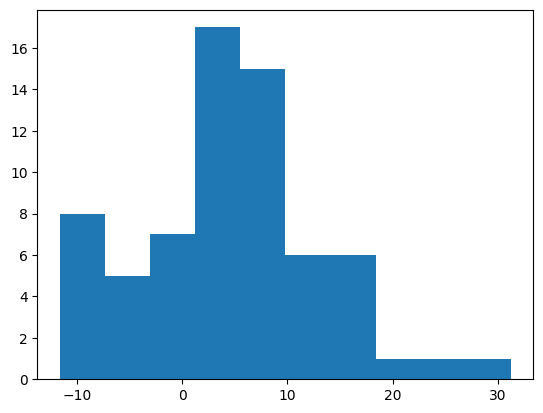

In [ ]:
plt.hist(results1)

In [ ]:
total_invest

[[507.6000061035156, 553.5999755859375],
 [1484.0, 1516.5, 1546.0, 1641.5, 1571.5],
 [151.3000030517578, 181.75],
 [1482.5999755859375, 1615.0],
 [554.7999877929688, 560.2000122070312],
 [51.560001373291016, 48.9900016784668, 53.41999816894531],
 [924.0, 923.2000122070312, 941.4000244140624, 1051.0, 1097.199951171875],
 [1510.0, 1510.0],
 [554.5999755859375, 513.5999755859375],
 [977.5999755859376, 995.4000244140624, 1044.5],
 [6000.0, 4560.5, 5434.0],
 [2238.0, 1812.5, 1924.5],
 [259.20001220703125,
  271.70001220703125,
  288.79998779296875,
  286.8999938964844,
  272.1000061035156,
  296.0],
 [2310.0, 2383.0, 2407.0],
 [4812.0, 5118.0],
 [104.3000030517578, 115.6999969482422, 116.94000244140624],
 [711.5999755859375, 696.0, 744.0],
 [2282.0, 2504.0],
 [7912.0, 7428.0],
 [2899.0, 3081.0],
 [726.5999755859375, 672.4000244140625, 693.7999877929688, 635.7999877929688],
 [361.2999877929688,
  364.2999877929688,
  361.1000061035156,
  334.5,
  334.5,
  323.5],
 [227.3500061035156,
  223.3

In [ ]:
import numpy as np

# Generate predicted returns (replace this with your actual predicted returns)
predicted_returns = results1

# Function to calculate statistic of interest (e.g., mean return)
def calculate_statistic(data):
    return np.mean(data)

# Number of bootstrap samples
num_bootstraps = 1000

# Initialize array to store bootstrapped statistics
bootstrapped_statistics = np.zeros(num_bootstraps)

# Perform bootstrapping
for i in range(num_bootstraps):
    # Resample with replacement
    resampled_returns = np.random.choice(predicted_returns, size=len(predicted_returns), replace=True)
    # Calculate statistic of interest
    bootstrapped_statistics[i] = calculate_statistic(resampled_returns)

# Calculate confidence intervals
confidence_interval = np.percentile(bootstrapped_statistics, [2.5, 97.5])

# Calculate original statistic
original_statistic = calculate_statistic(predicted_returns)

# Print results
print("Original Statistic:", original_statistic)
print("95% Confidence Interval:", confidence_interval)
if original_statistic < confidence_interval[0] or original_statistic > confidence_interval[1]:
    print("Original statistic is statistically significant.")
else:
    print("Original statistic is not statistically significant.")


Original Statistic: 4.250052395341858
95% Confidence Interval: [2.1965601  6.27182661]
Original statistic is not statistically significant.
